<a href="https://colab.research.google.com/github/malasimukombelwa/Apprentissage/blob/main/IDS_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [128]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.18.0


In [129]:

import pandas as pd
import numpy as np
data_train = pd.read_csv('/content/drive/MyDrive/Deep Learning Lesson/NSL-KDD_Train_5_classes.csv')
data_test = pd.read_csv('/content/drive/MyDrive/Deep Learning Lesson/NSL-KDD_Test_5_classes.csv')
x_train =data_train.iloc[:, :-1].values
y_train = data_train.iloc[:, 41].values
x_test =data_test.iloc[:, :-1].values
y_test = data_test.iloc[:, 41].values


In [130]:
import numpy as np
#Concate training and testing data to do the same preprocess steps
x = np.concatenate((x_train, x_test), axis = 0)

#Transform to numeric features
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# Encode Protocol type feature (3 different values)
labelencoder_x_1 = LabelEncoder()
x[:, 1] = labelencoder_x_1.fit_transform(x[:, 1])
# Encode Service feature (67 different values)
labelencoder_x_2 = LabelEncoder()
x[:, 2] = labelencoder_x_2.fit_transform(x[:, 2])

# Encode Flag feature (11 different values)
labelencoder_x_3 = LabelEncoder()
x[:, 3] = labelencoder_x_3.fit_transform(x[:, 3])


# Encoded by one-hot vector
from sklearn.compose import ColumnTransformer
# transform the second feature to 3-dim one-hot vector
ct = ColumnTransformer([("ProtocolType", OneHotEncoder(), [1])], remainder = 'passthrough')
x = ct.fit_transform(x)
# transform the third feature to 67-dim one-hot vector
ct = ColumnTransformer([("Service", OneHotEncoder(), [4])], remainder = 'passthrough')
x = ct.fit_transform(x)
# transform the fourth feature to 11-dim one-hot vector
ct = ColumnTransformer([("Flag", OneHotEncoder(), [71])], remainder = 'passthrough')
x = ct.fit_transform(x)



In [131]:
# Encode label (5 labels)
y = np.concatenate((y_train, y_test), axis = 0)
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)


In [132]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

# split to training and testing data
x_train = x[:90000,:]
x_test = x[58517:,:]

y_train = y[:90000]
y_test = y[58517:]

In [133]:
x.shape

(148517, 113)

In [134]:
y.shape

(148517,)

In [135]:
y_train

array([1, 1, 0, ..., 1, 1, 1])

In [136]:
y_test

array([0, 0, 1, ..., 0, 1, 2])

In [137]:

import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras import backend as K
import tensorflow as tf
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.18.0


In [138]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Layer

class DenseTranspose(Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super(DenseTranspose, self).__init__(**kwargs)
        self.dense = dense
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        # S'assurer que la couche Dense d'origine est bien construite
        if not self.dense.built:
            dummy_input = tf.zeros((1, batch_input_shape[-1]))  # Initialisation forcée
            _ = self.dense(dummy_input)

        # Récupération correcte des dimensions
        input_dim = self.dense.weights[0].shape[1]  # Correspond aux entrées d'origine
        output_dim = self.dense.weights[0].shape[0]  # Correspond aux sorties

        # Création des poids transposés avec la bonne forme
        self.W = self.add_weight(name="W_transposed", shape=(input_dim, output_dim),  # Transposition correcte
                                 initializer="glorot_uniform", trainable=True)
        self.biases = self.add_weight(name="bias", shape=(output_dim,), initializer="zeros", trainable=True)

        super().build(batch_input_shape)

    def call(self, inputs):
        # Multiplication avec des dimensions correctement alignées
        z = tf.linalg.matmul(inputs, self.W) + self.biases  # Plus de transposition nécessaire
        return self.activation(z) if self.activation else z

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.W.shape[1])  # Assure la compatibilité avec Keras


In [142]:

K.clear_session()
num_hidden = (113, 14, 28, 28)

Dense_11 = Dense(units=num_hidden[1], activation='sigmoid')
Dense_12 = Dense(units=num_hidden[2], activation='sigmoid')
Dense_13 = Dense(units=num_hidden[3], activation='sigmoid')

inputs_1 = Input(shape=(num_hidden[0],))

#Encoder
encoded_11 = Dense_11(inputs_1)
encoded_12 = Dense_12(encoded_11)
encoded_13 = Dense_13(encoded_12)



In [143]:
#Decoder
decoded_11 = DenseTranspose(Dense_13, activation='sigmoid')(encoded_13)
decoded_12 = DenseTranspose(Dense_12, activation='sigmoid')(decoded_11)
outputs_1 = DenseTranspose(Dense_11, activation='sigmoid')(decoded_12)

AE_1=Model(inputs_1, outputs_1)
Encoder_1=Model(inputs_1, decoded_12)

In [144]:
AE_1.compile(optimizer='rmsprop', loss= 'mse')
AE_1.fit(x_train,x_train,epochs=100,batch_size=256,shuffle=True)

Epoch 1/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1261
Epoch 2/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0360
Epoch 3/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0351
Epoch 4/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0349
Epoch 5/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0348
Epoch 6/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0348
Epoch 7/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0346
Epoch 8/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0346
Epoch 9/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0346
Epoch 10/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0346
Epoch 11/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0346
Epoch 12/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0346
Epoch 13/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0346
Epoch 14/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0346
Epoch 15/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 2

In [145]:
AE_1_encoded_train = Encoder_1.predict(x_train)
AE_1_encoded_test = Encoder_1.predict(x_test)


2813/2813 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


In [146]:
K.clear_session()
num_hidden = (14, 28, 28)

Dense_21 = Dense(units=num_hidden[1], activation='sigmoid')
Dense_22 = Dense(units=num_hidden[2], activation='sigmoid')


inputs_2 = Input(shape=(num_hidden[0],))

#Encoder
encoded_21 = Dense_21(inputs_2)
encoded_22 = Dense_22(encoded_21)


#Decoder
decoded_21 = DenseTranspose(Dense_22, activation='sigmoid')(encoded_22)
outputs_2 = DenseTranspose(Dense_21, activation='sigmoid')(decoded_21)

AE_2=Model(inputs_2, outputs_2)
Encoder_2=Model(inputs_2, decoded_21)

In [147]:
AE_2.compile(optimizer='rmsprop', loss= 'mse')
AE_2.fit(AE_1_encoded_train,AE_1_encoded_train,epochs=100,batch_size=256,shuffle=True)

Epoch 1/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0722
Epoch 2/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7.2254e-05
Epoch 3/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.3429e-05
Epoch 4/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.3522e-06
Epoch 5/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.7285e-06
Epoch 6/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.6872e-07
Epoch 7/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.6894e-07
Epoch 8/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.8753e-07
Epoch 9/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.9910e-08
Epoch 10/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.5328e-08
Epoch 11/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.1692e-08
Epoch 12/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.8675e-08
Epoch 13/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.1288e-08
Epoch 14/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.

In [126]:
AE_2_encoded_train = Encoder_2.predict(AE_1_encoded_train)
AE_2_encoded_test = Encoder_2.predict(AE_1_encoded_test)

2813/2813 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [148]:
from sklearn.ensemble import RandomForestClassifier
rfc1 = RandomForestClassifier(n_jobs=-1, n_estimators=10)
rfc1.fit(AE_2_encoded_train, y_train)
rfc1.score(AE_2_encoded_test, y_test)

0.9130444444444444

Epoch 1/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.9951e-11 - val_loss: 6.9737e-11
Epoch 2/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 7.0188e-11 - val_loss: 6.9701e-11
Epoch 3/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7.0056e-11 - val_loss: 6.9701e-11
Epoch 4/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.9921e-11 - val_loss: 6.9765e-11
Epoch 5/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.0178e-11 - val_loss: 6.9743e-11
Epoch 6/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.0167e-11 - val_loss: 6.9743e-11
Epoch 7/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.0260e-11 - val_loss: 6.9770e-11
Epoch 8/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.0073e-11 - val_loss: 6.9757e-11
Epoch 9/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.9810e-11 - val_loss: 6.9759e-11
Epoch 10/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.0076e-11 - val_loss: 6.9736e-11
Epoch 11/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/

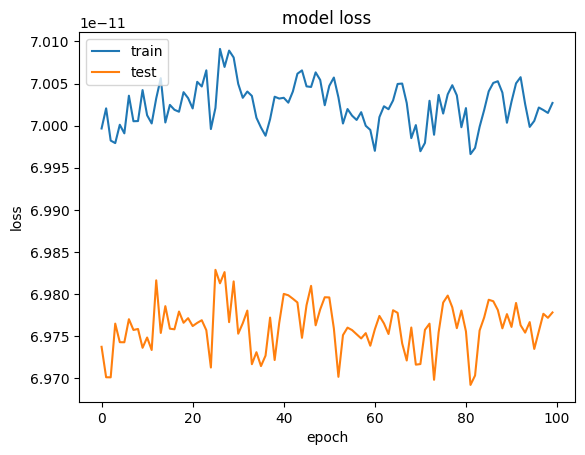

In [151]:
import matplotlib.pyplot as plt

# Assign the output of AE_2.fit to a variable called history
# Include validation_split or validation_data to calculate val_loss
history = AE_2.fit(
    AE_1_encoded_train,
    AE_1_encoded_train,
    epochs=100,
    batch_size=256,
    shuffle=True,
    validation_split=0.2  # Use 20% of training data for validation
)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])  # Now 'val_loss' should be available
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')  # Change legend label to 'validation'
plt.show()

In [153]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)  # ⚠ Utilisez transform() et non fit_transform()


In [154]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Layer

class DenseTranspose(Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super(DenseTranspose, self).__init__(**kwargs)
        self.dense = dense
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        # S'assurer que la couche Dense d'origine est bien construite
        if not self.dense.built:
            dummy_input = tf.zeros((1, batch_input_shape[-1]))  # Initialisation forcée
            _ = self.dense(dummy_input)

        # Récupération correcte des dimensions
        input_dim = self.dense.weights[0].shape[1]  # Correspond aux entrées d'origine
        output_dim = self.dense.weights[0].shape[0]  # Correspond aux sorties

        # Création des poids transposés avec la bonne forme
        self.W = self.add_weight(name="W_transposed", shape=(input_dim, output_dim),  # Transposition correcte
                                 initializer="glorot_uniform", trainable=True)
        self.biases = self.add_weight(name="bias", shape=(output_dim,), initializer="zeros", trainable=True)

        super().build(batch_input_shape)

    def call(self, inputs):
        # Multiplication avec des dimensions correctement alignées
        z = tf.linalg.matmul(inputs, self.W) + self.biases  # Plus de transposition nécessaire
        return self.activation(z) if self.activation else z

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.W.shape[1])  # Assure la compatibilité avec Keras


In [160]:
from keras.layers import Dropout, BatchNormalization
K.clear_session()
num_hidden = (113, 14, 28, 28)

Dense_11 = Dense(units=num_hidden[1], activation='sigmoid')
Dense_12 = Dense(units=num_hidden[2], activation='sigmoid')
Dense_13 = Dense(units=num_hidden[3], activation='sigmoid')

inputs_1 = Input(shape=(num_hidden[0],))

#Encoder
encoded_11 = Dense_11(inputs_1)
encoded_11 = BatchNormalization()(encoded_11)  # Normalisation
encoded_11 = Dropout(0.2)(encoded_11)  # Réduction d'overfitting
encoded_12 = Dense_12(encoded_11)
encoded_13 = Dense_13(encoded_12)

#Decoder
decoded_11 = DenseTranspose(Dense_13, activation='sigmoid')(encoded_13)
decoded_12 = DenseTranspose(Dense_12, activation='sigmoid')(decoded_11)
outputs_1 = DenseTranspose(Dense_11, activation='sigmoid')(decoded_12)

AE_1=Model(inputs_1, outputs_1)
Encoder_1=Model(inputs_1, decoded_12)

In [161]:
AE_1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='mse')
AE_1.fit(x_train, x_train, epochs=100, batch_size=512, shuffle=True)

Epoch 1/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2408
Epoch 2/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2067
Epoch 3/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1710
Epoch 4/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1372
Epoch 5/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1087
Epoch 6/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0875
Epoch 7/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0729
Epoch 8/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0631
Epoch 9/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0564
Epoch 10/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0517
Epoch 11/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0483
Epoch 12/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0458
Epoch 13/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0438
Epoch 14/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0423
Epoch 15/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1

In [162]:
AE_1_encoded_train = Encoder_1.predict(x_train)
AE_1_encoded_test = Encoder_1.predict(x_test)

2813/2813 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [163]:
K.clear_session()
num_hidden = (14, 28, 28)

Dense_21 = Dense(units=num_hidden[1], activation='sigmoid')
Dense_22 = Dense(units=num_hidden[2], activation='sigmoid')


inputs_2 = Input(shape=(num_hidden[0],))

#Encoder
encoded_21 = Dense_21(inputs_2)
encoded_22 = Dense_22(encoded_21)


#Decoder
decoded_21 = DenseTranspose(Dense_22, activation='sigmoid')(encoded_22)
outputs_2 = DenseTranspose(Dense_21, activation='sigmoid')(decoded_21)

AE_2=Model(inputs_2, outputs_2)
Encoder_2=Model(inputs_2, decoded_21)

In [164]:
AE_2.compile(optimizer='rmsprop', loss= 'mse')
history = AE_1.fit(x_train, x_train, validation_data=(x_test, x_test), epochs=100, batch_size=512, shuffle=True)

Epoch 1/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0207 - val_loss: 0.0214
Epoch 2/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0205 - val_loss: 0.0212
Epoch 3/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0204 - val_loss: 0.0211
Epoch 4/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0202 - val_loss: 0.0209
Epoch 5/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0202 - val_loss: 0.0207
Epoch 6/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0199 - val_loss: 0.0206
Epoch 7/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0198 - val_loss: 0.0204
Epoch 8/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0196 - val_loss: 0.0202
Epoch 9/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0195 - val_loss: 0.0201
Epoch 10/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0193 - val_loss: 0.0199
Epoch 11/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0193 - val_loss: 0.0197
Epoch 12/100
176/176 ━━━━━━━━━━━━━

In [165]:
AE_2_encoded_train = Encoder_2.predict(AE_1_encoded_train)
AE_2_encoded_test = Encoder_2.predict(AE_1_encoded_test)

2813/2813 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [166]:
from sklearn.ensemble import RandomForestClassifier
rfc1 = RandomForestClassifier(n_jobs=-1, n_estimators=10)
rfc1.fit(AE_2_encoded_train, y_train)
rfc1.score(AE_2_encoded_test, y_test)

0.8939777777777778

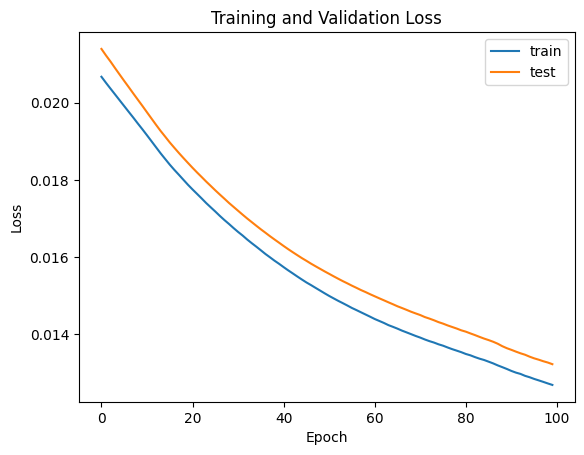

In [167]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()
